
# Filtering and pre-processing

Given the AnnData matrix created in the previous step, run some filtering and tooling steps for later processes.

In [1]:
import os
import collections

import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

/usr/local/lib/python3.6/dist-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


Load the AnnData matrix previously created. We have duplicate gene names in this matrix because of the merge step. We will only keep one of them.

In [2]:
adata = anndata.read_h5ad(os.path.join("write", "merged-final.h5ad"))

In [3]:
adata

AnnData object with n_obs × n_vars = 10126 × 27682 
    obs: 'batch', 'cellular_barcode'
    var: 'gene_names'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Filtering cells not present in Cellranger output

Cellranger does some extra filtering steps after the `.bam` files are generated. We have the list of barcodes that are present in the matrix produced by Cellranger. Anything not in that list will be removed from this analysis.

In [4]:
def add_cellranger_barcodes_to_set(batch, set_name):
    with open("source/{}.cellranger.cells.tsv".format(batch), 'r') as f:
        for cell in f:
            cell = cell.strip()
            set_name.add("{}-{}".format(cell, batch))

In [5]:
cellranger_barcodes = set()

for batch in ('control', 'BMP9', 'TGFB1', 'BMP9-TGFB1'):
    add_cellranger_barcodes_to_set(batch, cellranger_barcodes)

In [6]:
len(cellranger_barcodes)

7191

In [7]:
adata.obs.index.isin(cellranger_barcodes)

array([False, False, False, ...,  True,  True,  True])

In [8]:
adata = adata[adata.obs.index.isin(cellranger_barcodes)]

In [9]:
adata

View of AnnData object with n_obs × n_vars = 7150 × 27682 
    obs: 'batch', 'cellular_barcode'
    var: 'gene_names'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Identifying total count

From this data set, we will compute the total number of RNA molecules found in each cell.

In [10]:
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

Trying to set attribute `.obs` of view, making a copy.


In [11]:
adata.obs['n_counts']

index
TCTGCCAGTATACCCA-1-control         765.0
CAATTTCAGCACTAGG-1-control         801.0
TAGCACATCGTGAGAG-1-control         556.0
TCACACCTCTTCGACC-1-control        1400.0
TCGAAGTCAATTCACG-1-control        1387.0
                                  ...   
GCACATAAGCTGCGAA-1-BMP9-TGFB1    50795.0
GATGAGGTCAACCTTT-1-BMP9-TGFB1    65843.0
TACCGAAGTACCTTCC-1-BMP9-TGFB1    56837.0
TGCTTGCGTCCAGTTA-1-BMP9-TGFB1    55140.0
CATGCCTTCCCTCTTT-1-BMP9-TGFB1    53731.0
Name: n_counts, Length: 7150, dtype: float32

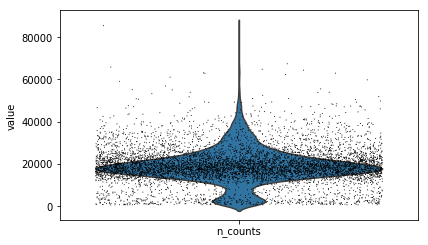

In [12]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

In [13]:
adata

AnnData object with n_obs × n_vars = 7150 × 27682 
    obs: 'batch', 'cellular_barcode', 'n_counts'
    var: 'gene_names'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Visualizing most expressed genes

Create a plot showing the genes that are found the most across our data set.

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


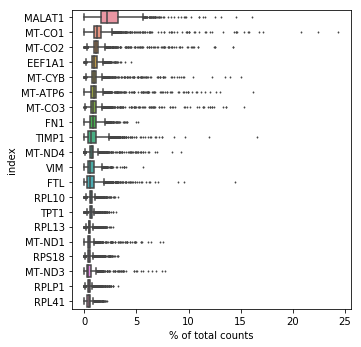

In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Filtering by gene and cell count

We will now we filter out cells that have fewer than a certain number expressed genes.

In [15]:
sc.pp.filter_cells(adata, min_genes=2000)

filtered out 478 cells that haveless than 2000 genes expressed


We now filter out genes that are expressed in fewer than a certain number of cells. Before doing so, we want to save a version of the complete list of genes for future analysis.

In [16]:
original_genes = list(adata.var["gene_names"])
sc.pp.filter_genes(adata, min_cells=100)

filtered out 12381 genes that are detectedin less than 100 cells


After this step, we have gotten additional information, including `n_genes`, automatically computing the number of genes found to be expressed in each cell.

## Identifying ratio of mitochondrial genes

We want to compute a ratio of mitochondrial genes to total count for each cell. This is important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [17]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.ravel(np.sum(
    adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))

Get number of mito genes in our gene set.

In [18]:
len([i for i in mito_genes if i])

13

Get number of mito gene counts per cell.

In [19]:
np.sum(adata[:, mito_genes].X, axis=1)

ArrayView([  16.,   87.,   33., ..., 4340., 4188., 4746.], dtype=float32)

Show violin plot of mito gene count ratio.

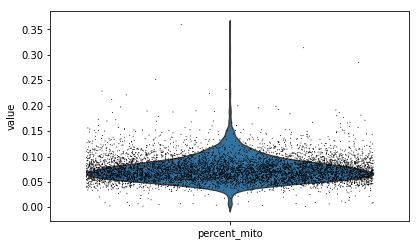

In [20]:
sc.pl.violin(adata, ['percent_mito'],
             jitter=0.4)

After these analyses, we have managed to compute the following metrics for our cells:

In [21]:
adata.obs

,batch,cellular_barcode,n_counts,n_genes,percent_mito
index,,,,,
GATAGAAGTCAAACGG-1-control,control,GATAGAAGTCAAACGG-1-control,4079.0,2003,0.003951
ATGAGGGGTCCGTACG-1-control,control,ATGAGGGGTCCGTACG-1-control,4320.0,2065,0.020209
AGACCCGTCGACACCG-1-control,control,AGACCCGTCGACACCG-1-control,5087.0,2073,0.006492
GAAGAATAGTTTAGGA-1-control,control,GAAGAATAGTTTAGGA-1-control,3766.0,2074,0.034179
AACCTGAAGCGAGTCA-1-control,control,AACCTGAAGCGAGTCA-1-control,5251.0,2099,0.078641
...,...,...,...,...,...
GCACATAAGCTGCGAA-1-BMP9-TGFB1,BMP9-TGFB1,GCACATAAGCTGCGAA-1-BMP9-TGFB1,50795.0,7652,0.075404
GATGAGGTCAACCTTT-1-BMP9-TGFB1,BMP9-TGFB1,GATGAGGTCAACCTTT-1-BMP9-TGFB1,65843.0,7670,0.152894
TACCGAAGTACCTTCC-1-BMP9-TGFB1,BMP9-TGFB1,TACCGAAGTACCTTCC-1-BMP9-TGFB1,56837.0,7849,0.076505


## Filtering by ratio of mitochondrial genes and total count

Filter out cells whose mitochondrial gene ratio or total count is too high based on these violin plots.

Scatter plot and matrix before filtering:

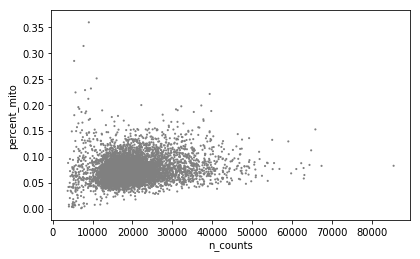

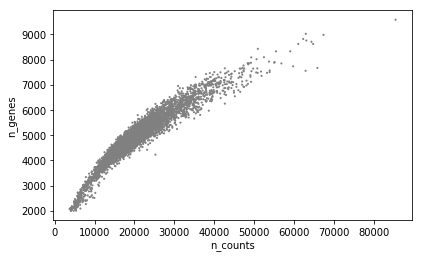

In [22]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [23]:
adata

AnnData object with n_obs × n_vars = 6672 × 15301 
    obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_names', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

Remove cells that have total counts >45000 or mitochondrial gene ratio >0.125. These are good numbers per the violin plots above.

In [24]:
adata = adata[adata.obs['n_counts'] < 45000, :]
adata = adata[adata.obs['n_counts'] > 10000, :]
adata = adata[adata.obs['percent_mito'] < 0.125, :]

Scatter plot, violin plot and matrix after filtering:

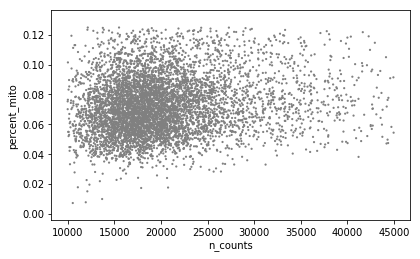

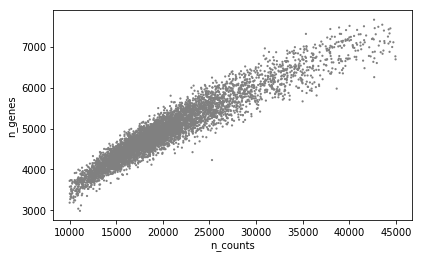

In [25]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

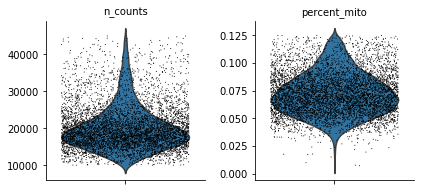

In [26]:
sc.pl.violin(adata, ['n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [27]:
adata

AnnData object with n_obs × n_vars = 6189 × 15301 
    obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_names', 'n_cells'
    layers: 'ambiguous', 'spliced', 'unspliced'

# Normalize total count

Now that we have filtered out outliers, we can normalize the count matrix by total count to reduce this source of variability. We will correct for the library size of the data matrix by rescaling it to 10000 reads per cell. Let us look at the unnormalized counts and perform the normalization:

In [28]:
adata.X.sum(1)

array([ 9981., 10393., 10384., ..., 41088., 44211., 44301.], dtype=float32)

In [29]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Let us inspect the new counts:

In [30]:
adata.X.sum(1)

array([10000., 10000., 10000., ..., 10000., 10000., 10000.], dtype=float32)

## Log total counts

Prior knowledge of microarray and bulkRNAseq means we know that a lot of effects are linear in the log of the total count, so it is a good idea to log the data now.

In [31]:
sc.pp.log1p(adata)

In [32]:
adata.X.sum(1)

array([3276.563 , 3309.313 , 3290.3362, ..., 4235.085 , 4326.5093,
       4329.029 ], dtype=float32)

## Identifying and filtering highly variable genes.

An important filtering metric is dispersion. Highly variable genes can be identified by this metric and filtered as important for future processing.

In [33]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


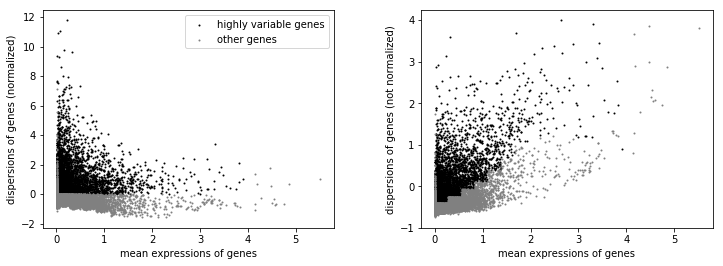

In [34]:
sc.pl.highly_variable_genes(adata)

Number of highly variable genes compared with non-highly variable genes:

In [35]:
collections.Counter(adata.var["highly_variable"])

Counter({False: 10695, True: 4606})

Let's save our genes list before filtering out non highly variable genes and do the actual filtering:

In [36]:
before_highly_variable_genes = list(adata.var["gene_names"])

In [37]:
adata = adata[:, adata.var['highly_variable']]

In [38]:
adata.uns["genes_original"] = original_genes
adata.uns["genes_before_highly_variable"] = before_highly_variable_genes

Trying to set attribute `.uns` of view, making a copy.


In [39]:
adata

AnnData object with n_obs × n_vars = 6189 × 4606 
    obs: 'batch', 'cellular_barcode', 'n_counts', 'n_genes', 'percent_mito'
    var: 'gene_names', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'genes_original', 'genes_before_highly_variable'
    layers: 'ambiguous', 'spliced', 'unspliced'

## Save filtered matrix to file

In [40]:
adata.write(os.path.join("write", "tgfb1-2.h5ad"))